In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:

# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

[]

In [ ]:
Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

In [ ]:
# Use `engine.execute` to select and display the first 5 rows from the measurement table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()


In [18]:
Base = automap_base()
# reflect an existing database into a new model
# reflect the tables
Base.prepare(engine, reflect=True)

In [19]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [20]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [16]:

#I.Design a query to retrieve the last 12 months of precipitation data and plot the results

#II.Calculate the date 1 year ago from today
#a: one_year_ago = [ last_date captured ] - [365 days/1 year]

#III.a: last_date calculation
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [17]:
#III.b: one_year_ago calculation
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

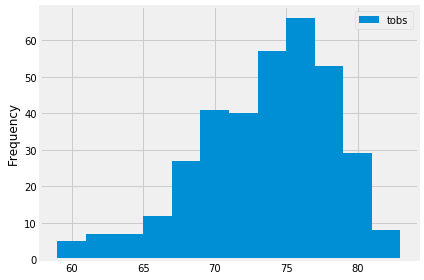

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import datetime as dt
from pandas.plotting import table
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()

In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

prev_year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62.0 68.36585365853658 74.0


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2018-01-01'
trip_end = '2018-01-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


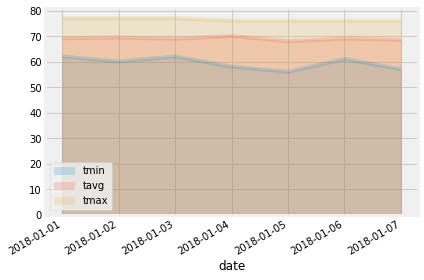

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()